# Interpolate between pairs of images
The code expects the images to be under '/content/drive/MyDrive/Colab Notebooks/data/48/'
This is another solution to implicit_2 but with autoencoder

Imports drive mount and cuda

In [11]:
import sys
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from skimage.io import imread_collection
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
image_resolution = 48

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8 * 12 * 12, 256),
            nn.LeakyReLU(True),
            nn.Dropout(0.2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(256, 8 * 12 * 12),
            nn.LeakyReLU(True),
            nn.Unflatten(1, (8, 12, 12)),
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Get all images, calculate mean std and build the transform and the dataloader

In [7]:
class ImageDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.transform(self.data[index])
        return x

    def __len__(self):
        return len(self.data)

img_dir = '/content/drive/MyDrive/Colab Notebooks/data/48/*.png'
images = imread_collection(img_dir)
imagesData = np.stack([img[:, :, :3] for img in images])
mean = np.mean(imagesData, axis=(0, 1, 2)) / 255
std = np.std(imagesData, axis=(0, 1, 2)) / 255
transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

imageDataSet = ImageDataset(imagesData, transform)
dataloader = DataLoader(imageDataSet, batch_size=100, pin_memory=True, num_workers=0, shuffle=False)

In [8]:
def show_image(im):
    normalized_img = np.moveaxis(im.view(3, image_resolution, image_resolution).cpu().detach().numpy(), 0, 2)
    plt.imshow(np.clip(255 * (normalized_img * std + mean), 0, 255).astype(np.int32))
    plt.show()

In [9]:
def train():
    model = Autoencoder().to(device)
    batch_losses = []
    train_losses = []

    epocs = 4000
    steps_til_summary = int(epocs/ 5)
    loss_function = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-8)

    for step in tqdm(range(epocs)):
        for images in dataloader:

            images = images.to(device)
            model_output = model(images)
            loss = loss_function(model_output, images)
            if not step % steps_til_summary:
                print("Step %d, Total loss %0.6f" % (step, loss))
            optim.zero_grad()
            loss.backward()
            batch_losses.append(loss.item())
            optim.step()
        train_losses.append(np.mean(batch_losses))

    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    # Plotting the last 100 values
    plt.plot(train_losses)
    plt.show()

    show_image(images[0])
    show_image(model_output[0])

    return model

  0%|          | 1/4000 [00:00<30:17,  2.20it/s]

Step 0, Total loss 1.050374


 20%|██        | 801/4000 [02:22<08:40,  6.14it/s]

Step 800, Total loss 0.122001


 40%|████      | 1601/4000 [04:38<07:31,  5.32it/s]

Step 1600, Total loss 0.117671


 60%|██████    | 2401/4000 [06:52<04:21,  6.11it/s]

Step 2400, Total loss 0.115603


 80%|████████  | 3202/4000 [09:13<02:02,  6.52it/s]

Step 3200, Total loss 0.118827


100%|██████████| 4000/4000 [11:29<00:00,  5.80it/s]


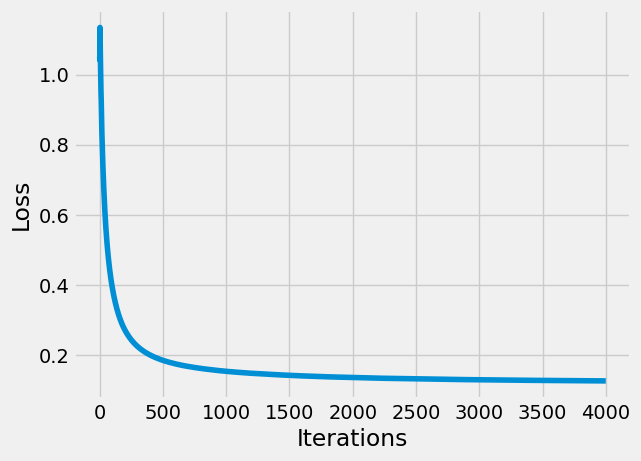

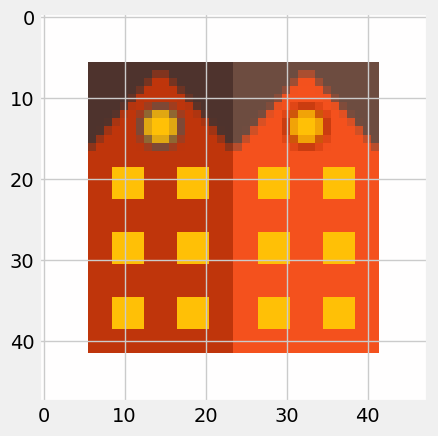

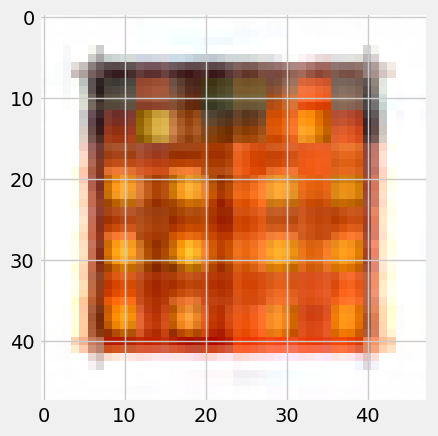

In [12]:
model_name = '/content/drive/MyDrive/Colab Notebooks/implicit_2b.pt'
if exists(model_name):
    loaded_state_dict = torch.load(model_name)
    model = Autoencoder().to(device)
    model.load_state_dict(loaded_state_dict)
    model.eval()
else:
    model = train()
    torch.save(model.state_dict(), model_name)

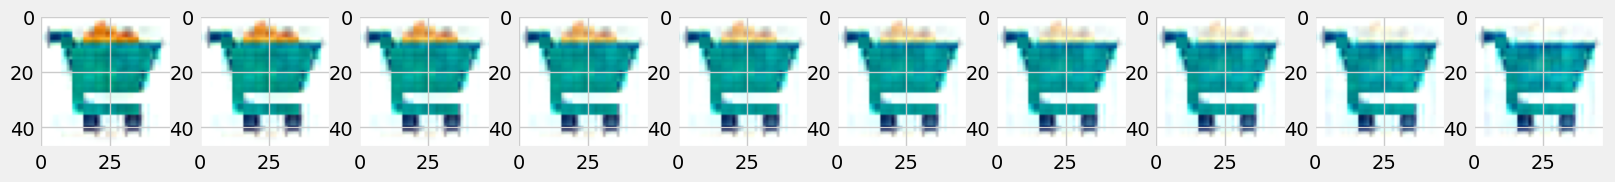

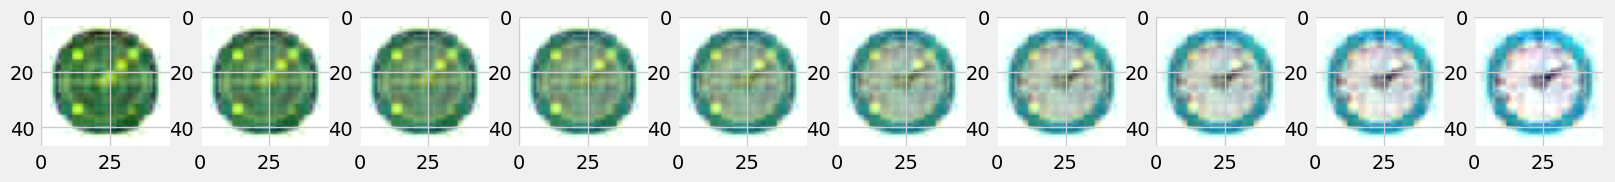

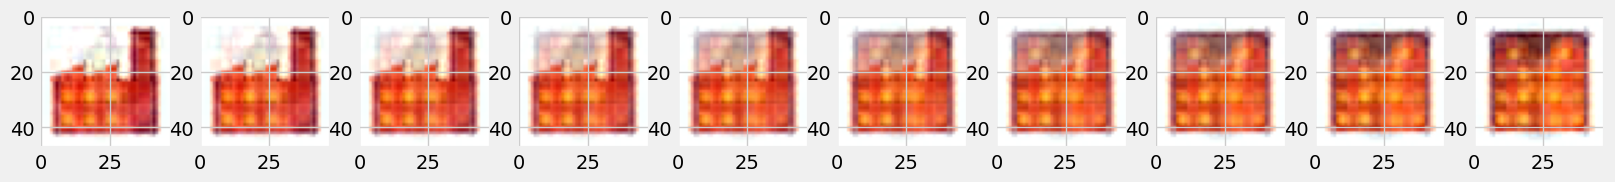

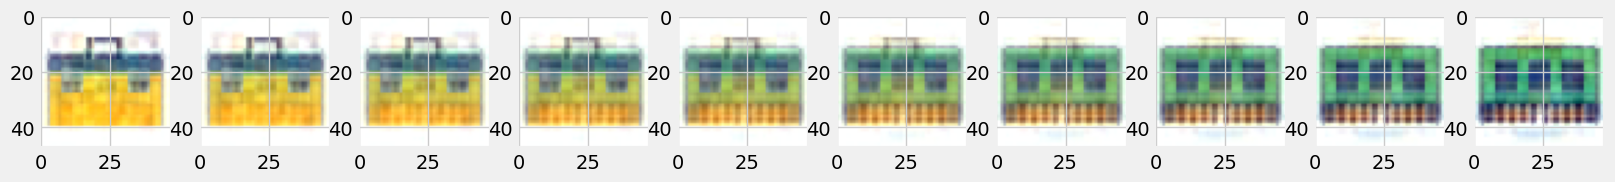

In [13]:
def interpolate(i,j):
    t = np.linspace(0,1,10)
    fig, axes = plt.subplots(1,10, figsize=(18,18))
    vec1 = model.encoder(transform(imagesData[i])[None, :].to(device))
    vec2 = model.encoder(transform(imagesData[j])[None, :].to(device))
    for i in range(10):
        vec = vec1.cpu().detach().numpy()*t[i]+vec2.cpu().detach().numpy()*(1-t[i])
        im = model.decoder(torch.from_numpy(vec).to(device))
        normalized_img = np.moveaxis(im.view(3, image_resolution, image_resolution).cpu().detach().numpy(), 0, 2)
        axes[i].imshow(np.clip(255 * (normalized_img * std[0] + mean[0]), 0, 255).astype(np.int32))
    plt.show()


for i, j in [[85,86],[24,74],[0,31],[55,93]]:
    interpolate(i,j)